<a href="https://colab.research.google.com/github/EmilianoLS/DiTellaML/blob/main/Customer%20Behaviour/Customer_Behaviour_Twitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installations
import sys
if 'google.colab' in sys.modules:
    !pip install emoji --upgrade
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !python -m spacy download en_core_web_lg
    #!pip install gensim
    !pip install chart_studio
    !pip install --upgrade autopep8
    !pip install pyldavis

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter
import random 

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

#Natural Language Processing (NLP)
import spacy
import nltk
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
stopwords = set(STOPWORDS)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [261]:
# Functions
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    #clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    clean_text = re.sub(r'<(.*?)>', '', text)
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

def get_top_words(sentiment, n):
  # Mean value of tfidf for every feature for every cluster 
  means_0 = tfidf_matrix[final_groups[(final_groups['cluster'] == 0) & (final_groups['sentiment'] == sentiment)].index].mean(0)
  #means_1 = tfidf_matrix[final_groups[(final_groups['cluster'] == 1) & (final_groups['sentiment'] == sentiment)].index].mean(0)

  # Get top 20 features for every cluster
  top_features_0_index = np.argpartition(np.array(means_0)[0], -n)[-n:]
  #top_features_1_index = np.argpartition(np.array(means_1)[0], -20)[-20:]

  # Get features
  # Create empty array
  top_0 = []
  #top_1 = []

  # Fill arrays

  for ind in top_features_0_index:
    top_0.append(tfidf.get_feature_names()[ind])

  #for ind in top_features_1_index:
  #  top_1.append(tfidf.get_feature_names()[ind])

  return top_0

In [ ]:
# Read data from Twitter
route = r'/content/drive/MyDrive/Colab Notebooks/datasets/tweets_nikekaepernick.csv'
df = pd.read_csv(route)

## Superficial explore

First thing to do is to explore the data in a superficial way. That means controling the type of features, explore the kind of data that they store, etc. I do this so I can understand what I am working with. 

Next steps would include getting deeper in the data. Like understanding the number of users in the dataset, average number of tweets and ohter kind of exploration. However, as mentioned before, the main goal of this report is not to explore too much on the rest of the features (at least, not right now) but actually, what is more interesting to look into is the *tweet_full_text* feature as it contains the actual tweet written. From this feature, we can explore the different topics that are trending. Even though this dataset is about the Nike Kaepernick campaign, we could still try to find different **topics**. 

Hopefully, we might find different groups (pro Nike vs Anti Nike, pro Campaign vs Anti Campaign, etc). As this is an exploratory analysis, whatever we find could be potentially interesting.

In [ ]:
# First glipse of dataset
df.head()

,tweet_lenght,tweet_favs_count,tweet_full_text,tweet_id,tweet_is_quote_bool,tweet_lang,tweet_rts_count,user_bio,user_favs_count,user_followers_count,user_id,user_name,user_statuses_count,user_verified
0,166,0,White ppl almost killing themselves just to bu...,x1037852811340464128,False,en,0,NaN,2035,559,x292503552,Dynasdee,44042,False
1,23,0,@madmoneymill Nike’s all I wear <U+0001F937><U...,x1037852910137237509,False,en,1,"Stay humble, and strive. USMC veteran. LLL©<U+...",33523,227,x935742289225355264,The_Phenom07,25593,False
2,29,2,@johnrich @Nike Do the same with your socks.. ...,x1037852694541520896,False,en,0,NaN,12,0,x481584622,guadalupelineck,17,False
3,12,1,@SNFonNBC I blame NIKE,x1037852896593735681,False,en,0,NaN,1757,75,x68105970,Jreeezy2000,5946,False
4,280,20,"@CBSNews hey hey hey,\r\nALL COLLEGES MATTER.\...",x1037852654930673664,False,en,3,"Business/Data Analyst, Educator, Authoress, AO...",12713,491,x4220625275,woodson_kb,18269,False


In [ ]:
# Obtainging the shape (rows and columns) of the dataset
df.shape

(11418, 14)

In [ ]:
# Getting feature information to make sure there is no need for casting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_lenght          11418 non-null  int64 
 1   tweet_favs_count      11418 non-null  int64 
 2   tweet_full_text       11418 non-null  object
 3   tweet_id              11418 non-null  object
 4   tweet_is_quote_bool   11418 non-null  bool  
 5   tweet_lang            11418 non-null  object
 6   tweet_rts_count       11418 non-null  int64 
 7   user_bio              9928 non-null   object
 8   user_favs_count       11418 non-null  int64 
 9   user_followers_count  11418 non-null  int64 
 10  user_id               11418 non-null  object
 11  user_name             11418 non-null  object
 12  user_statuses_count   11418 non-null  int64 
 13  user_verified         11418 non-null  bool  
dtypes: bool(2), int64(6), object(6)
memory usage: 1.1+ MB


## High level analysis

The most important or significant discoveries will come from analyzing the tweets in depth. However, a high level analysis, exploring the main atributes of the dataset is always recommended.

### User analysis

In [ ]:
# Number of unique users
users = len(df.user_id.unique())
avg_tweet_user = np.mean(df.groupby('user_id').agg({'tweet_id':'count'})['tweet_id'].tolist())
print(f'There are {users} unique users in the dataset')
print(f'Average number of tweets per user is: {round(avg_tweet_user, 3)}')

There are 10015 unique users in the dataset
Average number of tweets per user is: 1.14


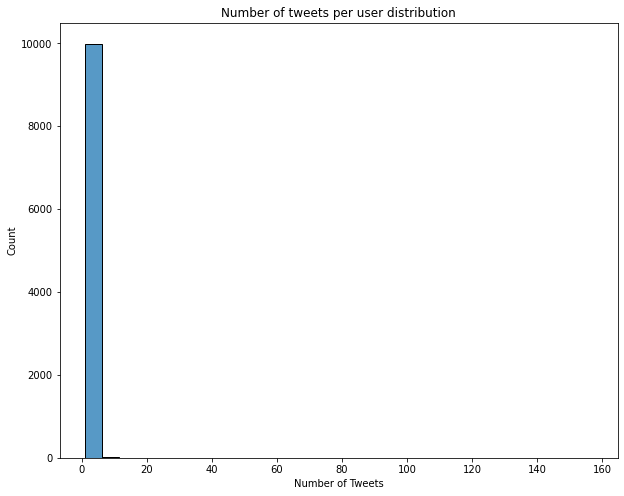

In [262]:
# Distribution of number of tweets per user
plt.figure(figsize = (10,8))
plt.title('Number of tweets per user distribution')
plt.xlabel('Number of Tweets')
sns.histplot(df.groupby('user_id').agg({'tweet_id':'count'})['tweet_id'], bins = 30)

Evidently, most of the users in the dataset tweeted only once.

### Boolean Features

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'User Verified')

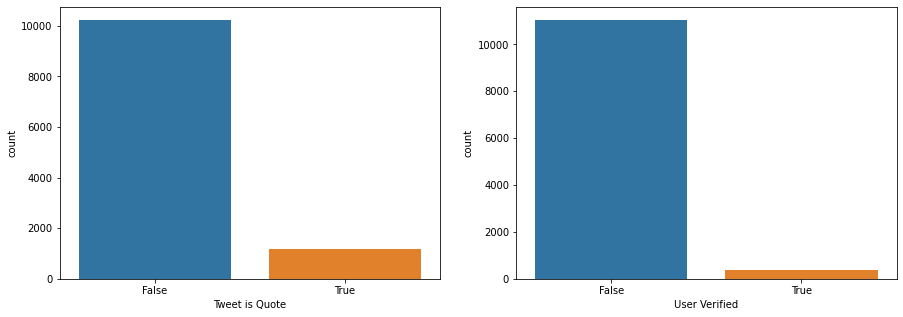

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

sns.countplot(df['tweet_is_quote_bool'], ax = ax[0])
sns.countplot(df['user_verified'], ax = ax[1])

ax[0].set_xlabel('Tweet is Quote')
ax[1].set_xlabel('User Verified')

From the results generated, most of the users are not verified, so not many official accounts are tweeting about the event. 

On the other hand, many tweets are original, which means that most of them are original and not simple retweets.

## Text Analysis

The time has come for a deep text annalysis. The strategy is simple (at least in theory):

* Cleaning and depurating the tweets: Removing stop words, tokenization, stemming, normalization of text, etc. In other words, I'm trying to keep only the relevant words
* Classifing into *positive, negative and neutral* groups
* Study the three groups in depth

At first, lets see what words we are working with:

In [ ]:
text = " ".join(review for review in df.tweet_full_text)
print ("There are {} words.".format(len(text)))

There are 1740277 words.


Another possible way of rapidly exploring the words being twited, we could plot a *WordCloud*. This plot is very helpfull as it shows the words according to the number of times it is being used. This can help us understand the most common words.

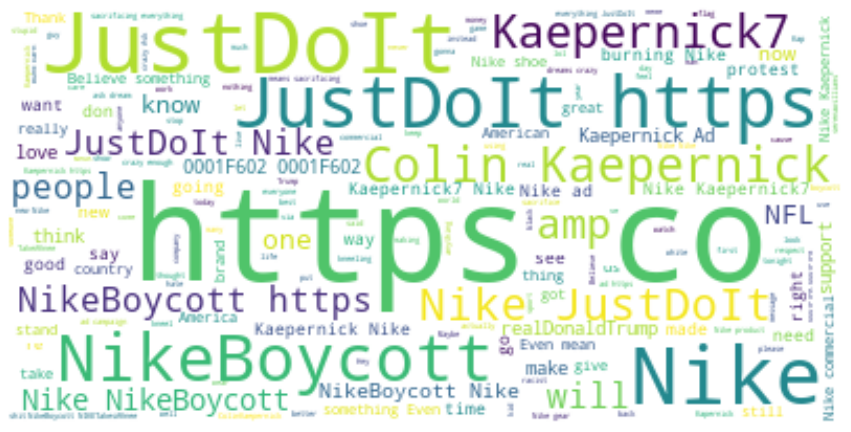

In [ ]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

So we can find some words that were expected like **Nike, JustDoIt and Kaepernick**. But there are some weird words like **https** which of course stands for an url. Evidently, a lot of tweets contain links to another web page. The problem is that this words are just noise, because they don't add any meaningfull information with respect to the subject on hand: The Nike controversy.

However, this is a very good start, the next step is to clean up a bit the tweets and retry this Wordcloud again.

In [ ]:
# Apply the function and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
df['emoji_free_tweets'] = df['tweet_full_text'].apply(call_emoji_free)

#Create a new column with url free tweets
df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)

Let's try the Wordcloud again and see what we can see now

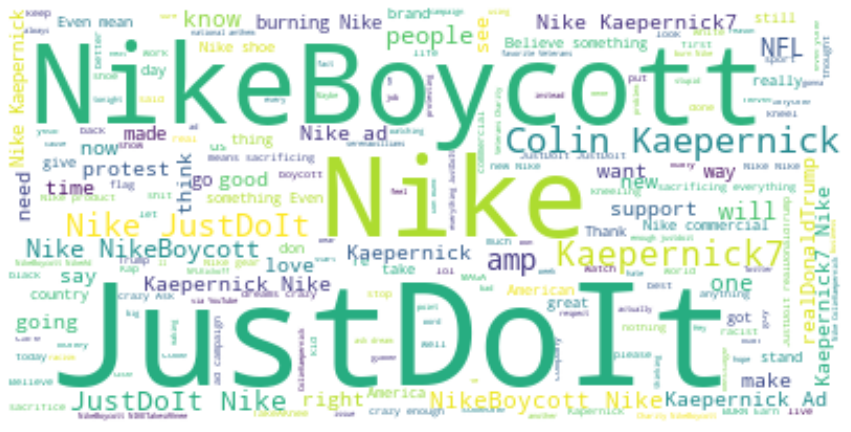

In [ ]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
text = " ".join(review for review in df.url_free_tweets)
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is looking better! We no longer have the **https** word bothering us. Just as expected, the common words are related to Nike, Colin or Boycott. Of course, this wordlcoud doesn't tell us anything about topics, nor groups among the tweets. Still, it is usefull for overlooking the text and be sure we are getting rid of noise.

### Tokenization

The process consists of extracting words from the different tweets while also cleaning a little bit the data: casting all to lower cases, removing stop words (common non informative words), etc.

In [ ]:
# Load spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
#custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$','nike',"nike's,'@"]
custom_stopwords = ['\n','\n\n', '&amp;', ' ', '.', '-']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

### Lemmatization

In [ ]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

# Get Lemmas
df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

### Drop mentions & Hashtags

Mentions will later be studied, besides, I don't want to confuse the model by providing mentions. They're not informative for the task of identifying sentiment in the sentences.

In [ ]:
# Eliminate mentions & Hashtags
df['clean_tweets'] = [re.sub(r'@[A-Za-z0-9_]+', '', x) for x in df['url_free_tweets']]
df['clean_tweets'] = [re.sub(r'[!¡?¿#0-9\r\n]+', '', x) for x in df['clean_tweets']]
df['clean_tweets'] = [x.lower() for x in df['clean_tweets']]

## Sentiment classification

I will be using two algorithms for this subject: TextBlob for handling text and SentimentIntensityAnalyzer for classifing.

In [ ]:
nltk.download('vader_lexicon')

# Calculating Negative, Positive, Neutral and Compound values
#lemma_text = [' '.join(map(str, l)) for l in df['lemma_tokens']]
#df['text'] = lemma_text

df[['polarity', 'subjectivity']] = df['clean_tweets'].apply(lambda x: pd.Series(TextBlob(x).sentiment))

for index, row in df['clean_tweets'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
   df.loc[index, 'sentiment'] = 'negative'
  elif pos > neg:
    df.loc[index, 'sentiment'] = 'positive'
  else:
    df.loc[index, 'sentiment'] = 'neutral'
    df.loc[index, 'neg'] = neg
    df.loc[index, 'neu'] = neu
    df.loc[index, 'pos'] = pos
    df.loc[index, 'compound'] = comp

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Let's explore the distribution for the negative, neutral and positive tweets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



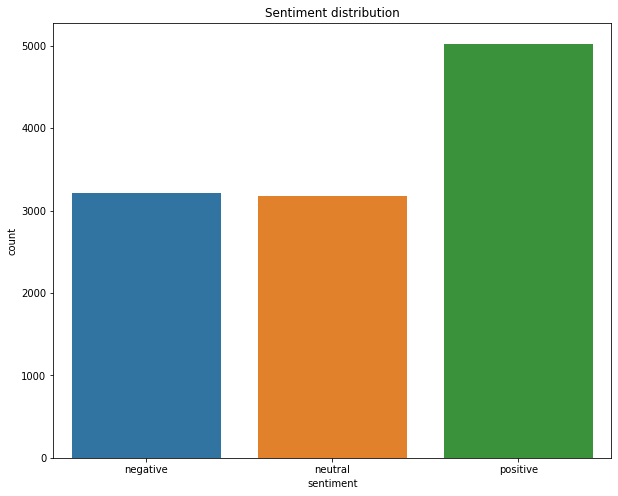

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Sentiment distribution')
sns.countplot(df.sentiment)

Surprinsignly, we find a majority of positive tweets. Even thought this is not concluding, it might be informing something interesting: Maybe Nike's campaign was well received by the public.

Let's take a look at the three groups word cloud and most popular words to see if we can identify any differences.

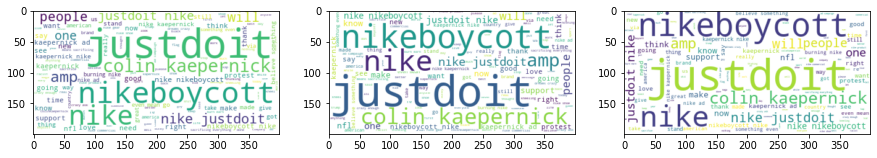

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,20))

# Generate a word cloud image
for sentiment, i in zip(['positive', 'negative', 'neutral'], [0,1,2]):
  text = " ".join(review for review in df.clean_tweets)
  wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize = (15,15))
  ax[i].imshow(wordcloud, interpolation='bilinear')
  #plt.axis("off")
  #plt.show()

What we can learn from these wordclouds is that it doesn't seem to be a lot of difference between the groups. However, it is expected that all three groups contain some words like **just do it** or **colin kaepernick** because that's what this dataset is about. 

On the other hand, if we take a look at some tweets from every group, we will notice that some are clearly against the campaign of burning Nike's products, others do have certain criticism towards Nike but not towards Kaepernick. Of course, this models are not perfect and we do have to keep that in mind while analyzing. 

The next step would be to classify every group into (at least) two different sub groups: a sub-positive and a sub-negative one. This is being done in an attempt to sepparate those that write *positively* against Nike (for example, "I think it's great what is happening to Nike" is a tweet that semantically could be classified as **positive** but the meaning behind it is against Nike. This difficulties at NLP problems are very common, especially when it comes to tweets, as they could be sarcastic but the models wouldn't know that very easily. 

## TfidfVectorizer 

In order to create the clusters for every sentiment group, the first thing to do would be to transform the text like tweets into something the algorithm can understand: numbers. In other words, I have to transform the tweets into a representable vector of numbers. 

There are many sofisticated models that could do the trick, but in this case I chose a simple option: Tfidf Vectorizer. 

The result after vectorizing will be a vector (obviously) as long as words the algorithm find in the dataset, with the tfidf score of every word. 

In [72]:
# Apply Tfidf Algorithm
tfidf = TfidfVectorizer(stop_words = stopwords)
tfidf_matrix = tfidf.fit_transform(df.clean_tweets)

# Get cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



## KMeans

Next step is to group similar vectors together. For this I will be using KMeans algorithm, setting at 2 clusters.

In [73]:
# Run Kmeans model
model = KMeans(n_clusters=3).fit(tfidf_matrix)

In [115]:
model_pos = KMeans(n_clusters=2).fit(tfidf_matrix[df[df['sentiment'] == 'positive'].index])
model_neg = KMeans(n_clusters=2).fit(tfidf_matrix[df[df['sentiment'] == 'negative'].index])
model_neu = KMeans(n_clusters=2).fit(tfidf_matrix[df[df['sentiment'] == 'neutral'].index])

### Assign Clusters

In [142]:
final_groups = df[['clean_tweets','sentiment']]

In [143]:
# Positive
subset_pos = final_groups[final_groups['sentiment'] == 'positive']
subset_pos['cluster'] = model_pos.labels_

# Negative
subset_neg = final_groups[final_groups['sentiment'] == 'negative']
subset_neg['cluster'] = model_neg.labels_

# Neutral
subset_neu = final_groups[final_groups['sentiment'] == 'neutral']
subset_neu['cluster'] = model_neu.labels_

# Join subsets
subset = pd.concat([subset_pos[['cluster']], subset_neg[['cluster']], subset_neu[['cluster']]], axis = 1)

# Fill nans
subset.fillna(0, inplace = True)

# Create final cluster feature
subset['final_cluster'] = subset.sum(axis = 1)
subset = subset[['final_cluster']]

# Merge with final_group
final_groups = pd.concat([final_groups, subset], axis = 1)
final_groups.rename(columns = {'final_cluster':'cluster'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [144]:
final_groups

,clean_tweets,sentiment,cluster
0,white ppl almost killing themselves just to bu...,negative,1.0
1,nike’s all i wear,neutral,0.0
2,do the same with your socks..,neutral,0.0
3,i blame nike,negative,1.0
4,"hey hey hey,all colleges matter.now , you app...",negative,1.0
...,...,...,...
11413,we have what we need. justdoit,neutral,0.0
11414,even the best can take an lmgk rapdevil justdo...,positive,0.0
11415,"serena all serena, of the last games. if you...",positive,0.0
11416,usopen tearing it up your tutu justdoit,neutral,0.0


In [148]:
# Clusters compositions for every sentiment
pd.crosstab(final_groups['sentiment'], final_groups['cluster'])

cluster,0.0,1.0
sentiment,,
negative,100,3118
neutral,3043,132
positive,4869,156


Most of the data is being assigned to one cluster in every sentiment. This suggests that there might not be a lot of variation among them, however, we could still annalize the words that are more relevant in each group, trying to identify any pro-Nike or against-Nike positions.

## Exploration of different groups

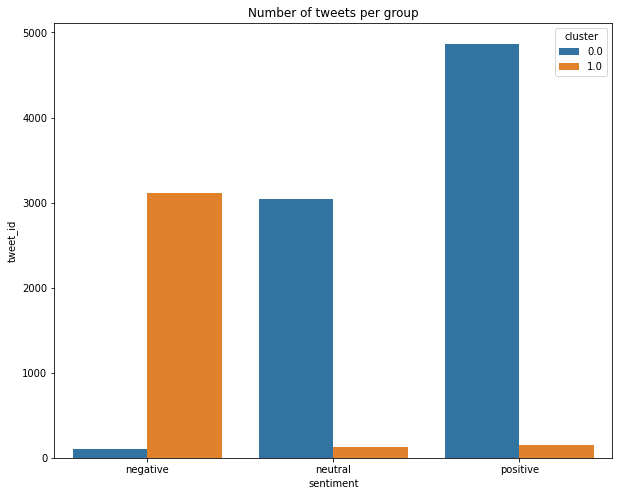

In [163]:
# Number of tweets per group
plt.figure(figsize = (10,8))
plt.title('Number of tweets per group')
test = df.groupby(['sentiment','cluster'], as_index = False).agg({'tweet_id':'count'})
sns.barplot(x = 'sentiment', y = 'tweet_id', hue = 'cluster', data = test)

Apparently, there is always a majority of tweets in each group of sentiment. What is prety clear is is that the positive group is the one with the most tweets posted.

Another possible analysis could be how many users each group has. But given our previous discovery that the mean average of tweets per user is almost 1, we could safely asume that the distribution will be very similar to the one we observe in this chart.

Finally, I believe it is safe to assume that there is no point in studying intra cluster differences, given that the majority of the tweets in every sentiment are assigned to one cluster in particular.

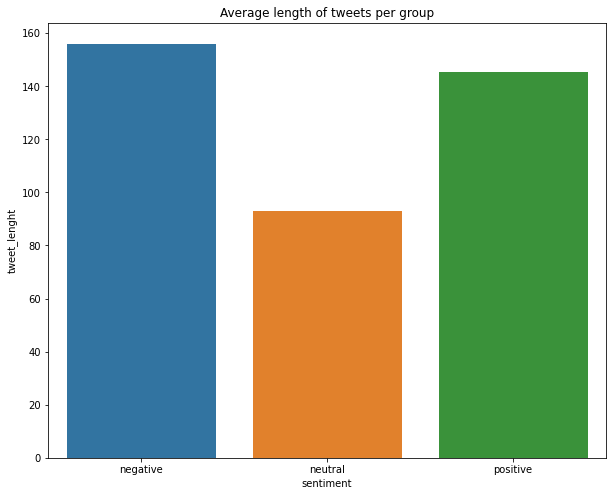

In [166]:
# Is there a difference in the lenght of the tweets between the groups
plt.figure(figsize = (10,8))
plt.title('Average length of tweets per group')
test = df.groupby(['sentiment'], as_index = False).agg({'tweet_lenght':'mean'})
sns.barplot(x = 'sentiment', y = 'tweet_lenght', data = test)

The neutral group seems to be the group in which users don't write too much. It makes sence as people who don't care or don't have a strong opinion will not discuss with long arguments because they are not trying to make a point.

On the other hand, positive and negative groups have a very similar average, maybe it is not significant. What is clear is that both extremes have the longer tweets. 

In [167]:
from scipy import stats

# Two Sided T-Test to check if the difference between the average tweet lenght 
# of positive and negative groups is significant

test_neg = df[df['sentiment'] == 'negative']['tweet_lenght']
test_pos = df[df['sentiment'] == 'positive']['tweet_lenght']
stats.ttest_ind(test_neg, test_pos)   

Ttest_indResult(statistic=6.3434456799528816, pvalue=2.365260174794322e-10)

We can confiendtly conclude that the negative group tends to have longer tweets than the positive ones.

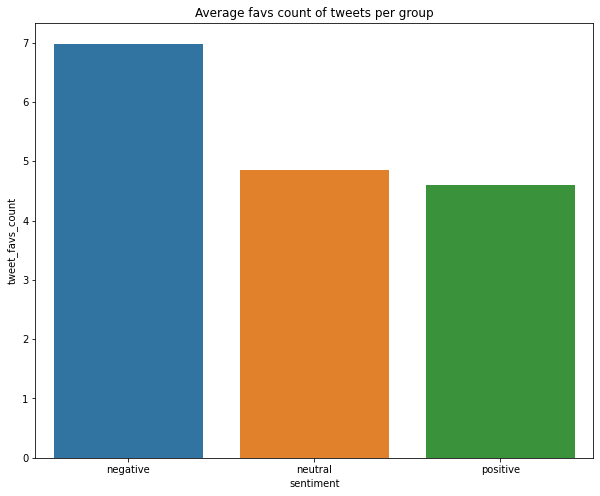

In [168]:
# How many favs does the tweets from every group have?

plt.figure(figsize = (10,8))
plt.title('Average favs count of tweets per group')
test = df.groupby(['sentiment'], as_index = False).agg({'tweet_favs_count':'mean'})
sns.barplot(x = 'sentiment', y = 'tweet_favs_count', data = test)

Apparently, negative tweets are more likely to be faved. Almost two times more than the other two groups. 

It is important to remark again that the negative group does not stand for users that are *against* the campaign or Nike. This group contains tweets that had a negative intention. The feeling could be directed towards the people burning socks, agaist the player or against Nike. There is no way to know just by looking at the group. 

In [169]:
# T-Test to check for significancy
test_neg = df[df['sentiment'] == 'negative']['tweet_favs_count']
test_pos = df[df['sentiment'] == 'positive']['tweet_favs_count']
stats.ttest_ind(test_neg, test_pos)   

Ttest_indResult(statistic=1.04356748609254, pvalue=0.29671615300048254)

Surprinsingly, although the difference seemed evident, there is no significant evidence that the average number of faved tweets is diferent between the groups.

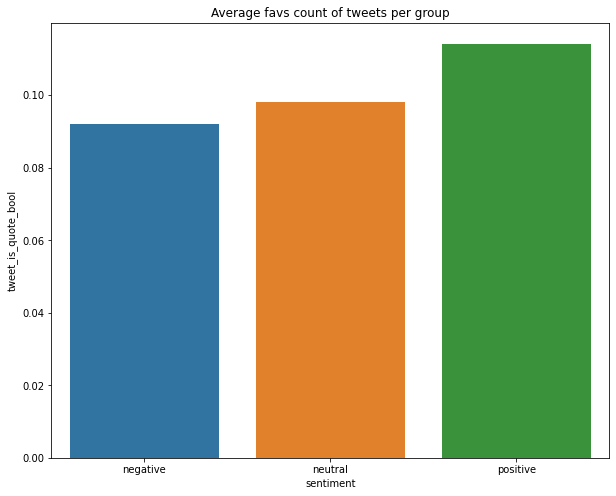

In [170]:
# Which group is being retweeted the most?

plt.figure(figsize = (10,8))
plt.title('Average favs count of tweets per group')
test = df.groupby(['sentiment'], as_index = False).agg({'tweet_is_quote_bool':'mean'})
sns.barplot(x = 'sentiment', y = 'tweet_is_quote_bool', data = test)

In [258]:
# T-Test to check for significancy
test_neg = df[df['sentiment'] == 'negative']['tweet_is_quote_bool']
test_pos = df[df['sentiment'] == 'positive']['tweet_is_quote_bool']
stats.ttest_ind(test_neg, test_pos)   

Ttest_indResult(statistic=-3.2084650540724127, pvalue=0.0013395622832103999)

Apparently, the positive group is composed of more retweets comments than the rest (at least, more than the negative group). 

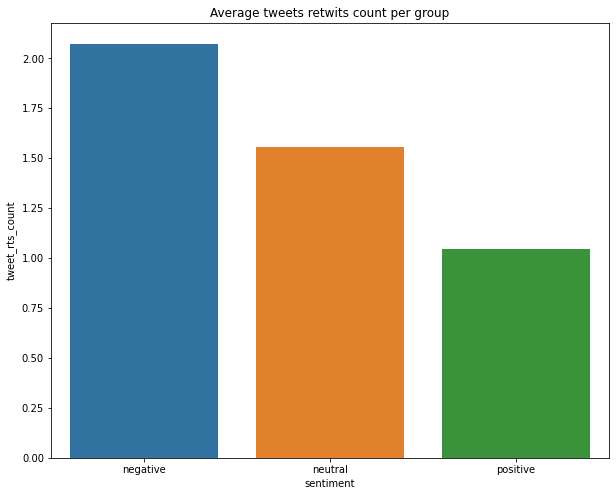

In [263]:
plt.figure(figsize = (10,8))
plt.title('Average tweets retwits count per group')
test = df.groupby(['sentiment'], as_index = False).agg({'tweet_rts_count':'mean'})
sns.barplot(x = 'sentiment', y = 'tweet_rts_count', data = test)

In [259]:
# T-Test to check for significancy
test_neg = df[df['sentiment'] == 'negative']['tweet_rts_count']
test_pos = df[df['sentiment'] == 'positive']['tweet_rts_count']
stats.ttest_ind(test_neg, test_pos)   

Ttest_indResult(statistic=2.1696716469397335, pvalue=0.03006021162844255)

This seems to show that in average, negative tweets are more likely to be retwited. This might indicate that negative comments are more popular.

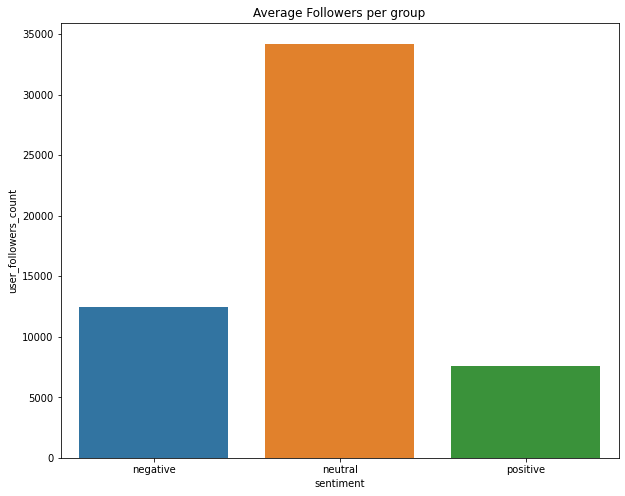

In [271]:
plt.figure(figsize = (10,8))
plt.title('Average Followers per group')
test = df.groupby(['sentiment'], as_index = False).agg({'user_followers_count':'mean'})
sns.barplot(x = 'sentiment', y = 'user_followers_count', data = test)

This is a surprise! Neutral comments users are the ones with the more followers. There could be many reasons for it:
* There could be a few outliers affecting the numbers
* The more extreme users are more discrete, small accounts.

Personally, I believe the outlier theory is the more likely. Just by looking at the numbers, you can tell that it is very weird. Of course, there is always the possibility that some brands accounts or some famous personality account was classified as neutral. That would explain the high numbers.

To check for this hypothesis, I will redo the plot from before, but using the *median*.

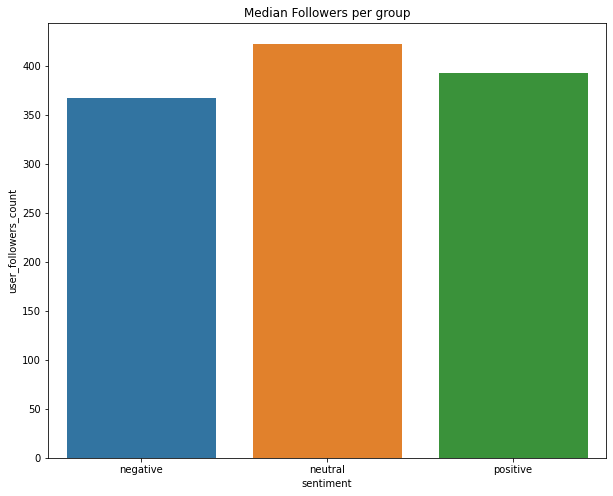

In [272]:
plt.figure(figsize = (10,8))
plt.title('Median Followers per group')
test = df.groupby(['sentiment'], as_index = False).agg({'user_followers_count':'median'})
sns.barplot(x = 'sentiment', y = 'user_followers_count', data = test)

This confirms that there are many outliers in the dataset, and in reality, the three groups are paired in the median number of followers.

### Top mentions by group

Another possible analysis could be the number of mentions in every group, and the accounts that are mentioned. 

A group with many mentions of Nike or Trump, could indicate an angry group, or vice versa.

In [235]:
# Get mentions in tweets
temp = [x.lower() for x in df['tweet_full_text']]
df['mentions'] = [re.findall(r'@[A-Za-z0-9_]+', x) for x in temp]

In [236]:
# Mentions: Positive
test_positive = [','.join(x) for x in df[df['sentiment'] == 'positive']['mentions']]
test_positive = [x for x in test_positive if x != '']
test_positive = np.concatenate([x.split(',') for x in test_positive])
test_positive = pd.DataFrame(test_positive, columns = ['mention'])
test_positive['q'] = 1
test_positive = test_positive.groupby('mention', as_index = False).sum()
test_positive = test_positive.sort_values(by = 'q', ascending = False).head(10)

# Mentions: Negative
test_negative = [','.join(x) for x in df[df['sentiment'] == 'negative']['mentions']]
test_negative = [x for x in test_negative if x != '']
test_negative = np.concatenate([x.split(',') for x in test_negative])
test_negative = pd.DataFrame(test_negative, columns = ['mention'])
test_negative['q'] = 1
test_negative = test_negative.groupby('mention', as_index = False).sum()
test_negative = test_negative.sort_values(by = 'q', ascending = False).head(10)

# Mentions: Neutral
test_neutral = [','.join(x) for x in df[df['sentiment'] == 'neutral']['mentions']]
test_neutral = [x for x in test_neutral if x != '']
test_neutral = np.concatenate([x.split(',') for x in test_neutral])
test_neutral = pd.DataFrame(test_neutral, columns = ['mention'])
test_neutral['q'] = 1
test_neutral = test_neutral.groupby('mention', as_index = False).sum()
test_neutral = test_neutral.sort_values(by = 'q', ascending = False).head(10)

Text(0.5, 1.0, 'Neutral')

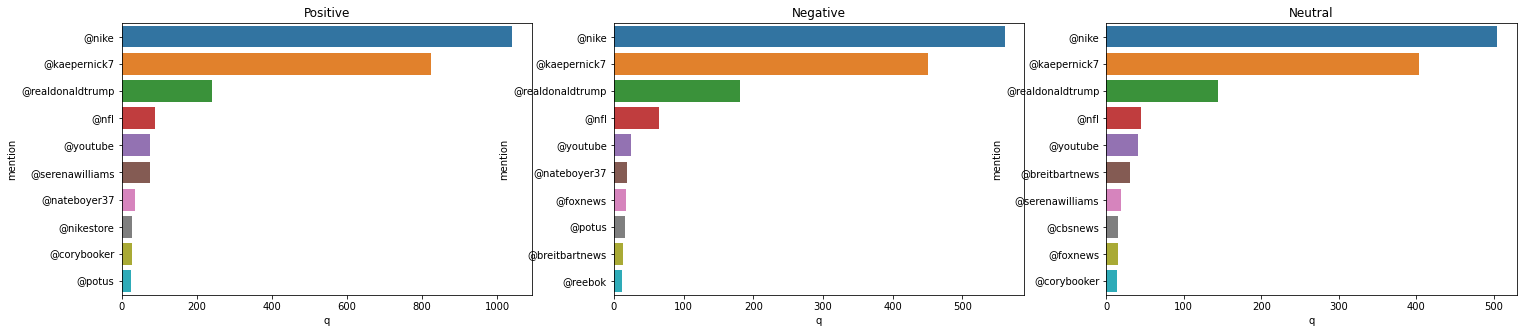

In [237]:
# Plot
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,5))

sns.barplot(x = 'q', y = 'mention', data = test_positive, ax = ax[0])
sns.barplot(x = 'q', y = 'mention', data = test_negative, ax = ax[1])
sns.barplot(x = 'q', y = 'mention', data = test_neutral, ax = ax[2])

ax[0].set_title('Positive')
ax[1].set_title('Negative')
ax[2].set_title('Neutral')

As expected, the top four mentions are:

* Nike
* Kaepernick
* Real Donald Trump
* NFL

And the numbers are very simmilar among groups. After that, the mentions vary significantly, but at the same time there are very few of them so we can safely ignore them. 

This results are not very rare, but still disapointing as I was hoping to find some kind of difference.

## Most common words used in the arguments of every group

Finally: What are the most common words in every group?

This might finally tell us more about the different sentiments. 

For this, I will use the Tfidf scores from before and extract the most used words in every group. After that I will plot those words with a WordCloud, as well as showing some examples from each group.

In [238]:
# Get most common words for every group
top_positive = get_top_words('positive', 20)
top_negative = get_top_words('negative', 20)
top_neutral = get_top_words('neutral', 20)

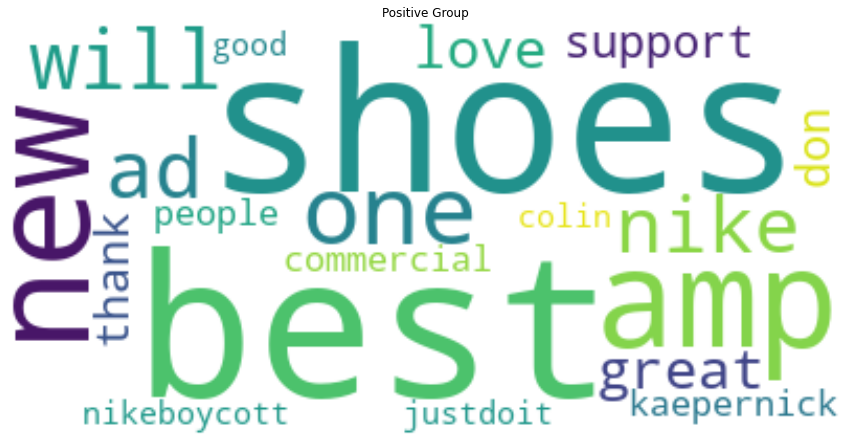

In [243]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
text = " ".join(review for review in top_positive)
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Group')
plt.show()

In [256]:
# Tweets sample from positive group
random.sample([x for x in temp if 'shoes' if 'love' if 'support' in x], 3)

['hint, hint: if you’re upset enough about @nike’s support for &amp; inclusion of @kaepernick7 in their campaign to rage on sm &amp; call for a #nikeboycott, the campaign isn’t for you. (1/6)',
 '@realdonaldtrump trump &amp; his #boycottnike supporters helped contribute to the $163.5 million in media exposure the brand already has received for its #justdoit campaign. you just can’t buy that level of stupidity everyday. #touchenike https://t.co/zjhjs9nzwo',
 "@reutersbiz @breakingviews there's nothing more republican than burning your own shoes to boycott them after you already bought them instead of giving them to homeless people who need them...i will continue to wear my nike and support all football player #takeaknee\r\n\r\n#nikeboycott https://t.co/2jvw22xhda"]

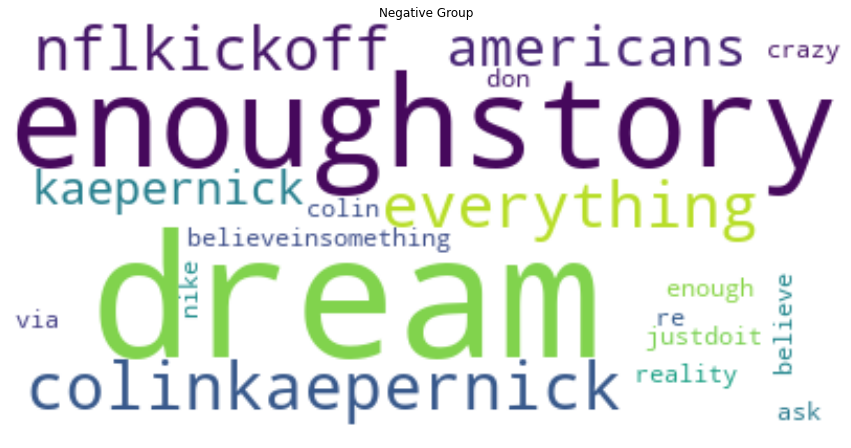

In [244]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
text = " ".join(review for review in top_negative)
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Group')
plt.show()

In [274]:
# Tweets sample from negative group
random.sample([x for x in temp if 'dream' if 'enoughstory' if 'americans' in x], 3)

['@seanhannity colin kaepernick &amp; nike sacrificed everything for a communist china that enriches themselves unjustly for slave labor instead of giving jobs to americans &amp; supporting our troops. support american business, support our troops, support the president &amp; american people, buy american. https://t.co/hw2bdno4bl',
 "for the people who think boycotting nike is right because of being associated with kaepernick, they should stop being ignorant asses. we are promoting blm and how it is wrong to kill innocent african americans. if you can't stand with that, then come mierda #nike",
 '@theogphrosty2 @rbduval77 @bluntstatement @im18ctown @ellehcimecnesse @avecope @amysuds @nbcnewsthink @nateboyer37 @kaepernick7 this isn’t a conservative vs liberal conversation. it was a matter of fact. he made a remark how castro was globally good for african americans. never mind the fact he was slaughtering his own people.']

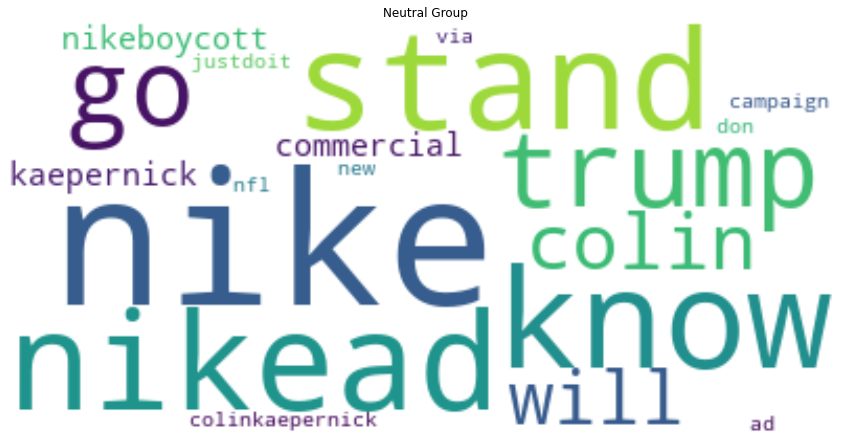

In [245]:
# Create a wordcloud for overlooking the most common words
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
text = " ".join(review for review in top_neutral)
wordcloud = WordCloud(stopwords = stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Neutral Group')
plt.show()

## Conclusion

Frist things first. As mentioned before, the sentiment clustering is not perfect! It depends on many things:

* Good cleaning of tweets (outliers, missing data, duplicated information, etc)
* Good tokenization and lemmatization
* The technique used for clustering
* Wether the tweet is sarcastic or honest

And many more. 

That being said, the two main groups (negative and positive) have some some subtle differences. Just as I mentioned at the beggining of the assignment, these classification is suposed to separate "good" comments from "bad" ones. That doesn't necessarily means that positive comments will be related to Nike supportive tweets or that the negative tweets will be against the NFL player. The clustering is purely lexic. Besides, there is no clear way of assign value to this posts, not with the provided data at least. Number of retwits or likes could go either way.

If I had to guess (and this is my personal opinion) based on the few samples extracted from every group, the global oppinion is against the Nike boycott, and especially against burning or damaging Nike products.

I found that positive comments tend to be less agressive, contain less insults and are against damaging Nike products. 

On the other hand, negative comments are much more violent, users tend to insult the people who are against Nike. 

Based on the number of times Nike was mentioned in every group, I would say that this campaign could not damage (at least severly) Nike's image. If anything, the protest and all the movement around the brand is giving them more marketing, and they are not even paying by it! Of course, I could not say the same about Kaepernick or any other celebrity related to Nike, but that's not the goal of the assignment.

On the other hand, significant differences were found among the groups in terms of lenght, retweets and user followers. 

Just as I mentioned before, angry comments tend to be larger, and based on the comments I read from the sample, this is true. Users tend to write much more and in detail about their opinions.

Also, negative tweets are more likely to be retwited, wich lead me to believe that there is a certain morbidity in relation with violent and negative opinions. However, this could also mean that this tweets are very popular, and people share them because they agree with them. This is not necessarily good for Nike. Taking into account that negative comments are more violent, maybe a violent community is not a good image for the brand. 

In my final opinion, much more data an analysis is needed. A much more sophisticated model could be use to correctly separate positive from negative comments. Of course, Nike move was a bold one, it generated a lot of reactions, but in general people were against the boycott and it certainly didn't damage Nike.